In [56]:
import sys
sys.version

'3.7.6 (default, Jan  8 2020, 13:42:34) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

In [57]:
import pandas as pd
pd.__version__

'0.24.2'

In [58]:
import sklearn
sklearn.__version__

'0.23.2'

In [59]:
import time
import itertools
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
import numpy as np
from numpy import sort
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm

In [60]:
# dataset path
dataset_path = './csv/diff_dataset.csv'
testset_path = './csv/diff_testset.csv'

In [61]:
# read dataset
dataset = pd.read_csv(dataset_path)
testset = pd.read_csv(testset_path)

In [62]:
# drop unnamed column
dataset.drop(columns=['Unnamed: 0'], inplace=True)
testset.drop(columns=['Unnamed: 0'], inplace=True)

In [63]:
# remove resolve state
data_drop_index = dataset[dataset['v_type_code'] %2 == 0].index.tolist()
dataset.drop(index=data_drop_index, axis=0, inplace=True)
test_drop_index = testset[testset['v_type_code'] %2 == 0].index.tolist()
testset.drop(index=test_drop_index, axis=0, inplace=True)

# data_57 = dataset[dataset['v_type_code'].isin([5,7])].index.tolist()
# dataset.drop(index=data_57, axis=0, inplace=True)

# test_57 = testset[testset['v_type_code'].isin([5,7])].index.tolist()
# testset.drop(index=test_57, axis=0, inplace=True)

print('dataset:')
print(dataset.shape)
print('testset:')
print(testset.shape)

column = dataset.columns

dataset:
(930, 996)
testset:
(840, 996)


In [64]:
X_train = dataset[column[:-1]]
X_test = testset[column[:-1]]
y_train = dataset[column[-1]]
y_test = testset[column[-1]]

X = pd.concat([X_train, X_test], axis=0, ignore_index=True, sort=False)
Y = pd.concat([y_train, y_test], axis=0, ignore_index=True, sort=False)
#     X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(X.shape, Y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1770, 995) (1770,)
(930, 995) (930,)
(840, 995) (840,)


In [65]:
ss = StandardScaler()
std_X_train = ss.fit_transform(X_train)
std_X_test = ss.fit_transform(X_test)

In [66]:
# XGBoost
def xgboost(X_train, y_train, X_test, y_test, show=False, plt_show=True):
    last_time = time.time()
    xgb = XGBClassifier(n_estimators=100, objective='multi:softprob', num_class=4, random_state=0)
    xgb.fit(X_train, y_train)
    middle_time = time.time()
    y_pred = xgb.predict(X_test)
    current_time = time.time()
    accuracy_score(y_test, y_pred)

#     print("train time： {}".format(middle_time - last_time))
#     print("test time： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        report=classification_report(y_test, y_pred, output_dict=True)
        return report

In [67]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red")
        # color="red" if cm[i, j] > thresh else "black")
    # plt.set_tight_layout(True)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [68]:
model = XGBClassifier(importance_type='gain',n_estimators=100)
model.fit(X, Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

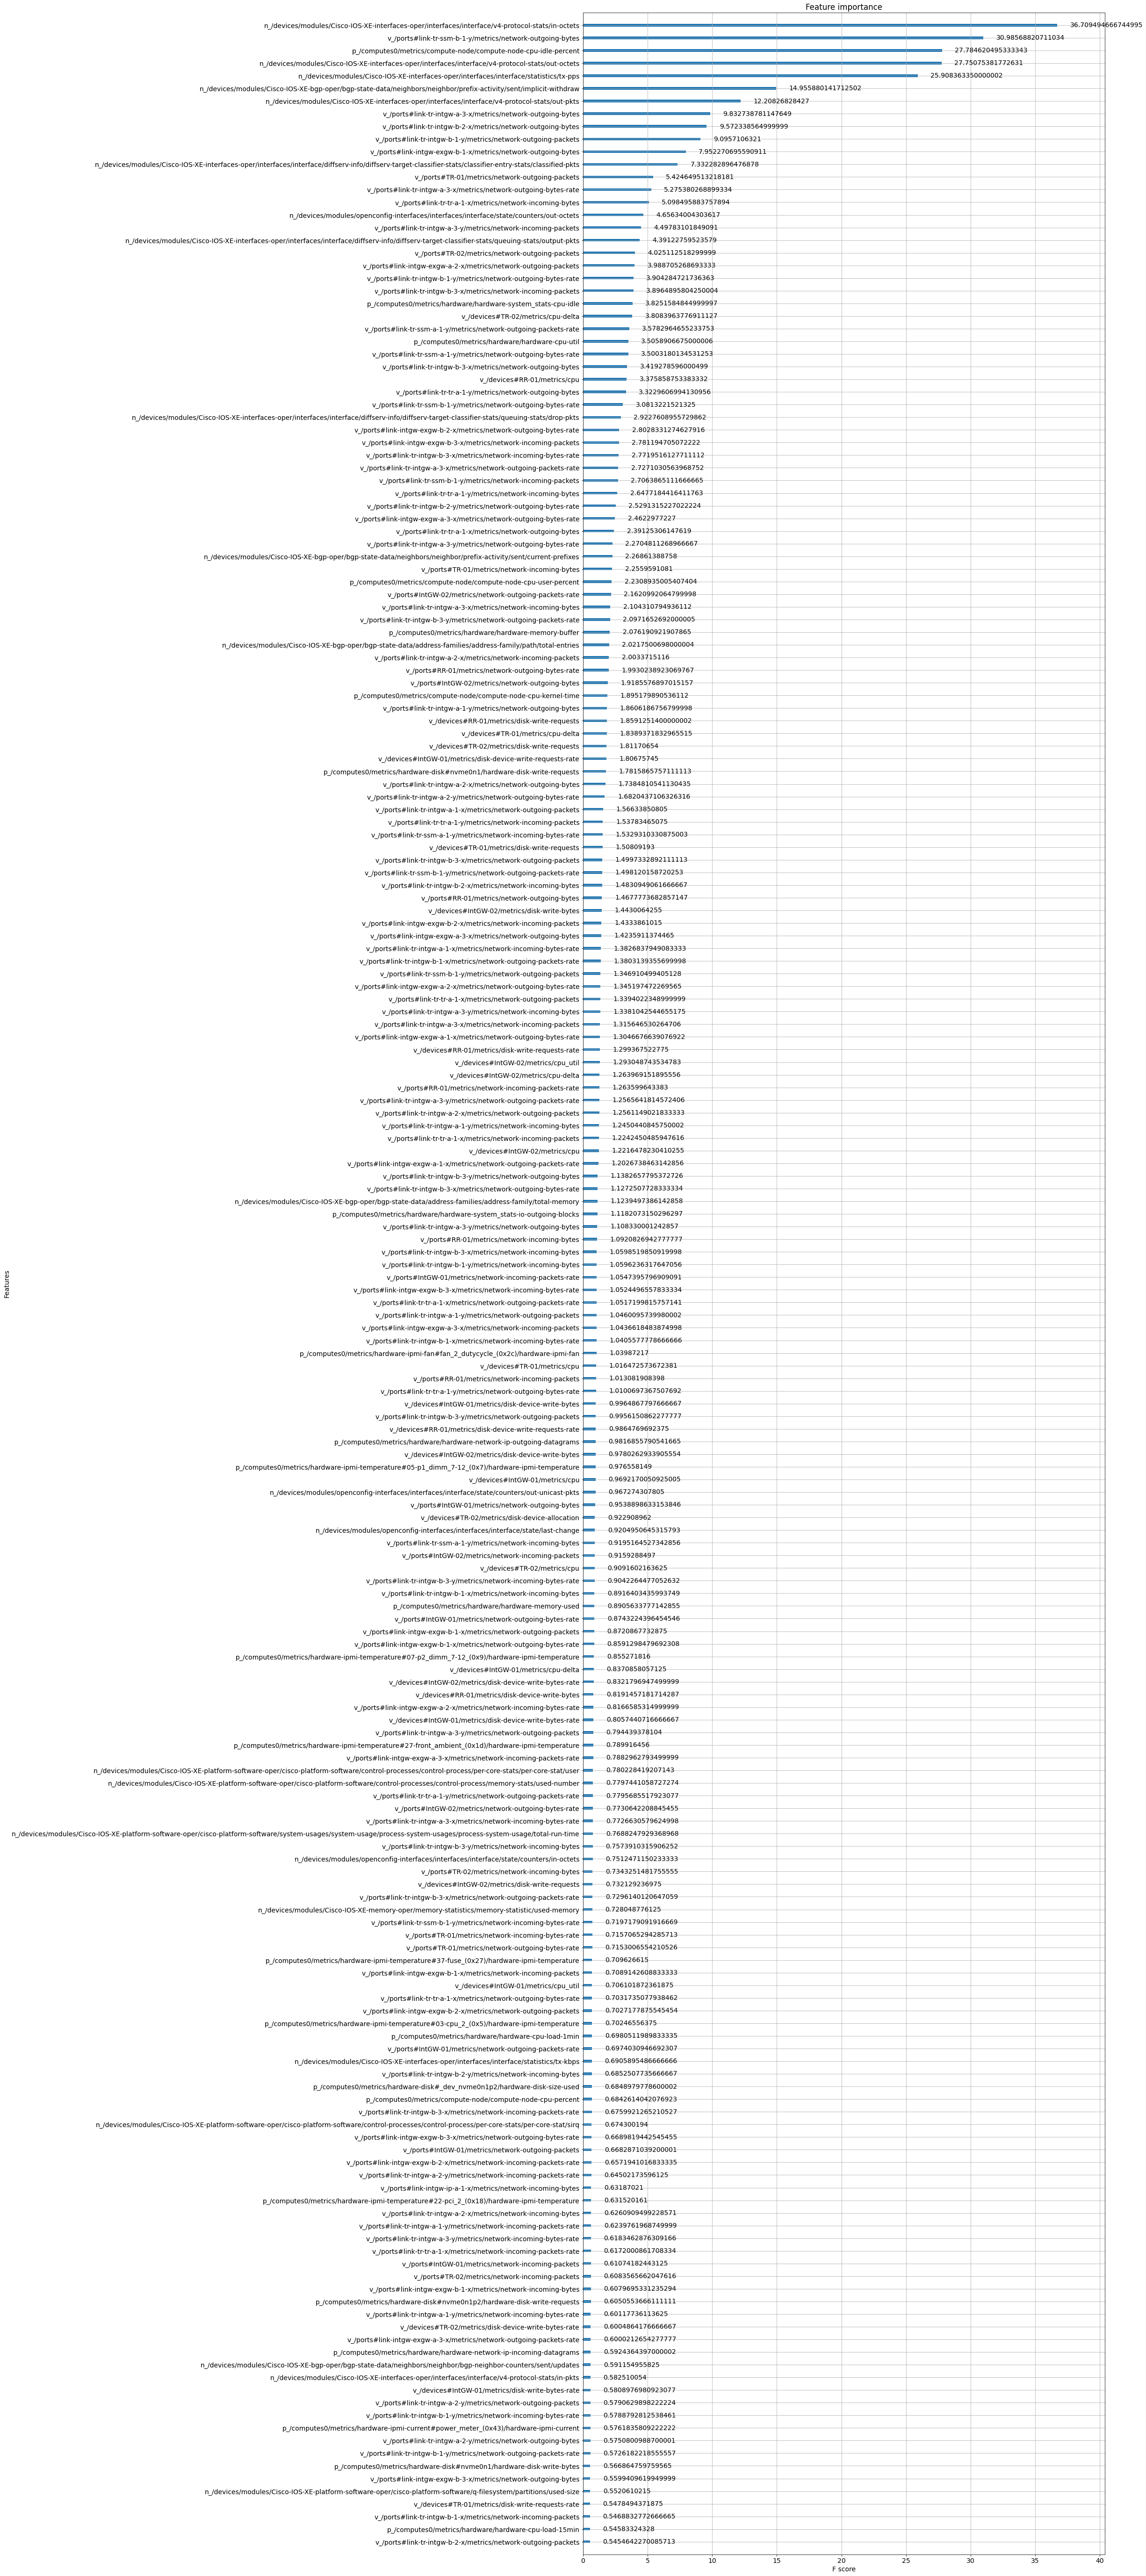

In [69]:
_, ax = plt.subplots(figsize=(20, 100))
plt.rc('font', size=14)
plt.rc('axes', labelsize=14) 
plot_importance(model, ax=ax, max_num_features=200, importance_type='gain')
plt.show()

In [36]:
im=pd.DataFrame({'importance':model.feature_importances_,'var':X.columns})
im=im.sort_values(by='importance',ascending=False)
im.to_csv("feature_important_data_XG_1015.csv")

In [70]:
thresholds = sort(model.feature_importances_)[-200:]
print(thresholds)

[0.00102127 0.00102196 0.00102392 0.00102573 0.00103362 0.00104837
 0.00106133 0.00107211 0.00107671 0.00107878 0.00108383 0.00108417
 0.00108761 0.00109063 0.00110681 0.00110921 0.00112341 0.00112428
 0.00112558 0.00113284 0.00113829 0.00113902 0.00114348 0.00115558
 0.00115772 0.00116826 0.00117222 0.00118239 0.00118304 0.00120767
 0.00123046 0.00125122 0.00125253 0.00126248 0.00126565 0.00128113
 0.00128232 0.00128299 0.00129298 0.00130574 0.00130695 0.00131522
 0.00131569 0.00131654 0.00132202 0.00132729 0.00132862 0.00133925
 0.00134001 0.00134752 0.00136312 0.00136605 0.00137076 0.00137487
 0.00140655 0.00141805 0.00143946 0.00144665 0.0014474  0.00145958
 0.0014599  0.00146081 0.00147592 0.00147895 0.00148742 0.00150858
 0.00152902 0.00153368 0.00155808 0.00156726 0.00160131 0.00160854
 0.0016328  0.00163698 0.00166739 0.00166941 0.00169297 0.00170221
 0.00171488 0.0017216  0.00172343 0.00172795 0.00178595 0.00181101
 0.00181465 0.0018284  0.00183114 0.001838   0.00184697 0.0018

In [71]:
list_1=[]
list_3=[]
list_5=[]
list_7=[]
list_9=[]
list_11=[]
list_acc=[]

for thresh in thresholds:
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    select_X_test = selection.transform(X_test)
    # 格式：'1': {'precision': 0.9824561403508771, 'recall': 0.875, 'f1-score': 0.9256198347107438, 'support': 64}
    report = xgboost(select_X_train, y_train, select_X_test, y_test,show=True)
    list_1.append(report['1']['precision'])
    list_3.append(report['3']['precision'])
    list_5.append(report['5']['precision'])
    list_7.append(report['7']['precision'])
    list_9.append(report['9']['precision'])
    list_11.append(report['11']['precision'])
    list_acc.append(report['accuracy'])
    print("Thresh=%.4f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], report['accuracy'] * 100.0))

Thresh=0.0010, n=200, Accuracy: 75.36%
Thresh=0.0010, n=199, Accuracy: 76.31%
Thresh=0.0010, n=198, Accuracy: 75.95%
Thresh=0.0010, n=197, Accuracy: 76.07%
Thresh=0.0010, n=196, Accuracy: 77.38%
Thresh=0.0010, n=195, Accuracy: 76.43%
Thresh=0.0011, n=194, Accuracy: 76.55%
Thresh=0.0011, n=193, Accuracy: 77.50%
Thresh=0.0011, n=192, Accuracy: 76.43%
Thresh=0.0011, n=191, Accuracy: 76.19%
Thresh=0.0011, n=190, Accuracy: 76.90%
Thresh=0.0011, n=189, Accuracy: 76.43%
Thresh=0.0011, n=188, Accuracy: 76.43%
Thresh=0.0011, n=187, Accuracy: 76.90%
Thresh=0.0011, n=186, Accuracy: 75.60%
Thresh=0.0011, n=185, Accuracy: 76.67%
Thresh=0.0011, n=184, Accuracy: 75.71%
Thresh=0.0011, n=183, Accuracy: 76.55%
Thresh=0.0011, n=182, Accuracy: 76.43%
Thresh=0.0011, n=181, Accuracy: 76.07%
Thresh=0.0011, n=180, Accuracy: 76.31%
Thresh=0.0011, n=179, Accuracy: 77.26%
Thresh=0.0011, n=178, Accuracy: 75.36%
Thresh=0.0012, n=177, Accuracy: 75.48%
Thresh=0.0012, n=176, Accuracy: 76.90%
Thresh=0.0012, n=175, Acc

In [72]:
print(len(list_1))

200


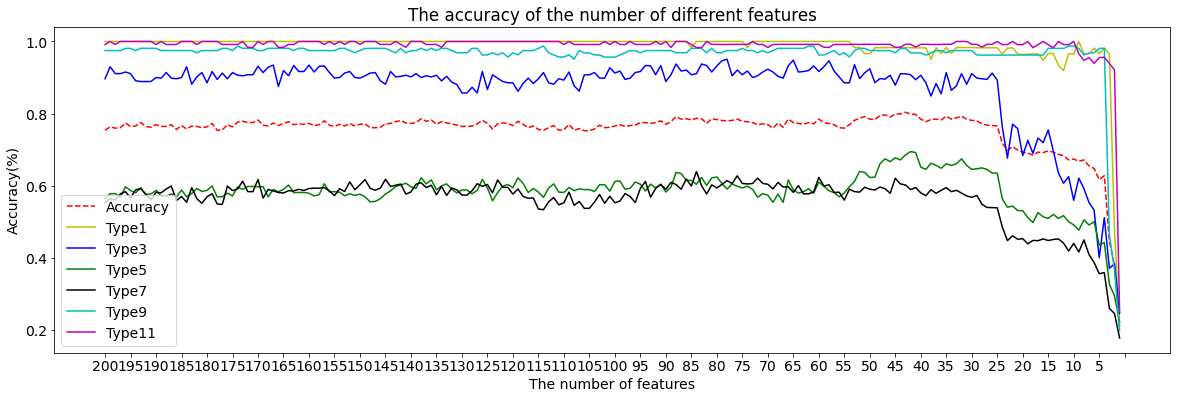

In [73]:
# X_train result
x_n = [str(200-x) for x in range(200)]
plt.figure(figsize=(20, 6))
plt.rc('font', size=14)
plt.rc('axes', labelsize=14) 
plt.plot(x_n,list_acc,'r--',label='Accuracy')
plt.plot(x_n,list_1,'y',label='Type1')
plt.plot(x_n,list_3,'b',label='Type3')
plt.plot(x_n,list_5,'g',label='Type5')
plt.plot(x_n,list_7,'k',label='Type7')
plt.plot(x_n,list_9,'c',label='Type9')
plt.plot(x_n,list_11,'m',label='Type11')
plt.legend(loc='lower left')
plt.title('The accuracy of the number of different features')
plt.xlabel('The number of features')
plt.ylabel('Accuracy(%)')
plt.xticks(np.arange(200,-5,-5))
plt.show()

In [ ]:
from sklearn.decomposition import PCA

In [43]:
pca=PCA(n_components=30)     #加载PCA算法，设置降维后主成分数目为自动
reduced_X=pca.fit_transform(X)#对样本进行降维


In [44]:
# random forest
def random_forest(X_train, y_train, X_test, y_test, show=False):
    last_time = time.time()
    rf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)

    rf.fit(X_train, y_train)
    middle_time = time.time()

    y_pred = rf.predict(X_test)

    current_time = time.time()

    print("Accuracy: %.2f"% accuracy_score(y_test, y_pred))

    print("训练耗时： {}".format(middle_time - last_time))
    print("测试耗时： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix rf:')
        print(cm)
        print('classification report rf:')
        print(classification_report(y_test, y_pred))

        plot_confusion_matrix(cm, classes=['1', '3', '9', '11'],
                              normalize=True, title='Normalized confusion matrix')

        plt.show()

Accuracy: 0.79
训练耗时： 0.16594672203063965
测试耗时： 0.012247085571289062
confusion matrix rf:
[[ 63   0   0   2]
 [  8  78  35   0]
 [  1  18 158   2]
 [  1   4  40 110]]
classification report rf:
              precision    recall  f1-score   support

           1       0.86      0.97      0.91        65
           3       0.78      0.64      0.71       121
           9       0.68      0.88      0.77       179
          11       0.96      0.71      0.82       155

    accuracy                           0.79       520
   macro avg       0.82      0.80      0.80       520
weighted avg       0.81      0.79      0.79       520

Normalized confusion matrix
[[0.96923077 0.         0.         0.03076923]
 [0.0661157  0.6446281  0.2892562  0.        ]
 [0.00558659 0.10055866 0.88268156 0.01117318]
 [0.00645161 0.02580645 0.25806452 0.70967742]]


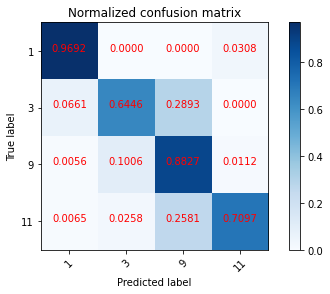

In [45]:
reduced_X_train, reduced_X_test, reduced_y_train, reduced_y_test = train_test_split(reduced_X, Y, test_size=0.7)
random_forest(reduced_X_train, reduced_y_train, reduced_X_test, reduced_y_test, show=True)